In [1]:
!git clone https://github.com/JagdishKolhe/MammographicMassClassification.git

Cloning into 'MammographicMassClassification'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [39]:
import numpy as np
import pandas as pd

import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [40]:
train_file = "/content/MammographicMassClassification/Train.xlsx"

test_file = "/content/MammographicMassClassification/Test.xlsx"

In [41]:
# Read excel file, and drop Index colum. OR read only required colums from excel using usecols parameter.

test_pd = pd.read_excel(test_file, usecols=["BI_RADS", "Age", "Shape", "Margin", "Mass_Density", "Severity"])
train_pd = pd.read_excel(train_file, usecols=["BI_RADS", "Age", "Shape", "Margin", "Mass_Density", "Severity"])

print("%d records in train" %(len(train_pd)))

811 records in train


# Check for null values in the data.

Lets try building the model by droping the na values. Later we can try imputing NA values.

There are multiple ways to fill na values.
1. Use mean or median or mode. Before choosing we shuld consider the  distribution of the data. eg. if we  have outliers then mean, median and mode values affects a lot.
2. Try finding nearest neighbour for the missing value and pickup the value form that nearest neighbour.


For now lets choose to drop the NA


In [42]:
x_train_pd = train_pd.dropna()
x_train_pd.reset_index(drop=True, inplace=True)
print("%d records in train, after dropna" %(len(x_train_pd)))


610 records in train, after dropna


In [43]:
x_train_pd

,BI_RADS,Age,Shape,Margin,Mass_Density,Severity
0,5.0,67.0,lobular,spiculated,low,1
1,5.0,58.0,irregular,spiculated,low,1
2,4.0,28.0,round,circumscribed,low,0
3,5.0,57.0,round,spiculated,low,1
4,5.0,76.0,round,ill-defined,low,1
...,...,...,...,...,...,...
605,5.0,5.0,irregular,ill-defined,iso,1
606,5.0,62.0,irregular,ill-defined,iso,1
607,4.0,56.0,oval,circumscribed,low,0
608,5.0,58.0,irregular,ill-defined,low,1


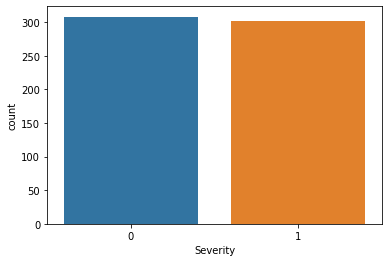

In [44]:
sns.countplot(x="Severity", data=x_train_pd)

From above plot, Overall we can say that the data is balenced, and we are good to go with further analysis.

In case if data is imbalance, we can balence it using following polular techniques
1. SMOTE (Synthetic Minority Over-sampling Technique)
2. Random under-sampling and over-sampling


On the other hand we can use different types of algorithm like trees, RandomForest which are prone to imbalenced data. Also, we can fine tune the model threshold using AUC/ROC curves. 

In [45]:
# print('\n', x_train_pd['Shape'].value_counts())
# print('\n', x_train_pd['Margin'].value_counts())
# print('\n', x_train_pd['Mass_Density'].value_counts())

print(pd.unique(x_train_pd['Shape']))
print(pd.unique(x_train_pd['Margin']))
print(pd.unique(x_train_pd['Mass_Density']))

print("\n")
print(pd.unique(test_pd['Shape']))
print(pd.unique(test_pd['Margin']))
print(pd.unique(test_pd['Mass_Density']))

['lobular' 'irregular' 'round' 'oval']
['spiculated' 'circumscribed' 'ill-defined' 'obscured' 'microlobulated']
['low' 'iso' 'high' 'fat-containing']


['lobular' 'oval' 'irregular' 'round' nan]
['ill-defined' 'microlobulated' 'circumscribed' nan 'obscured'
 'spiculated']
['low' 'fat-containing' 'iso' 'high']


# Plot fraction of patients with respect to Severity versus age

Here we will try to find proportionately how many people are affected w.r.t Age.

This proportionate can also be considerd as probablity of having malignant w.r.t. Age 

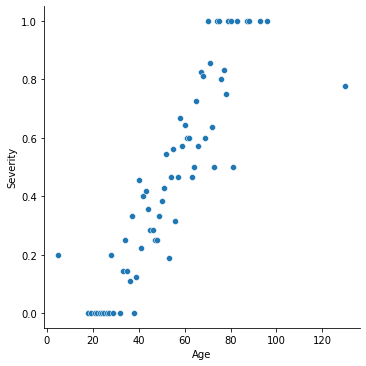

In [46]:
grouped = x_train_pd.groupby('Age')
age_mean = grouped.mean()
sns.relplot(x="Age", y="Severity", data=age_mean)

# age_mean

Above plot shows that, **higher the age, higher** the chances of **Severity**

In other words, age is an important decision making feature.

# Lets look at **Shape** now.

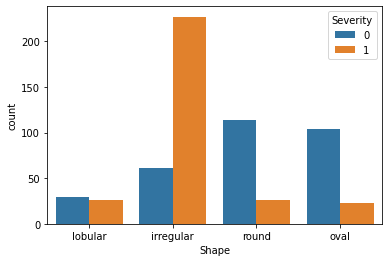

In [47]:
grouped = x_train_pd.groupby('Shape')
age_mean = grouped.count()

sns.countplot(x="Shape", data=x_train_pd, hue="Severity")

Bar plot for **Shape** as above, says that **irregular** shape means very high chance of Malignant. Whereas round and oval shape means less Severity. lobular Shape has almost equal chance of Malignant/benign

This means, Shape is also very important feature.

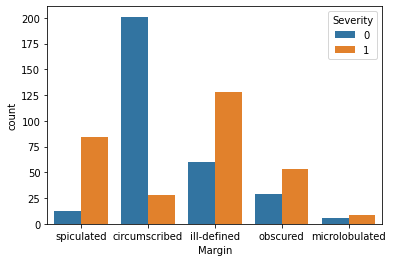

In [48]:
grouped = x_train_pd.groupby('Margin')
age_mean = grouped.count()

sns.countplot(x="Margin", data=x_train_pd, hue="Severity")

From above plot, We can say, **Margin** is also the deciding factor.

Circumscrbed means less Severity, Whereas ill-defined means High Severity and so on.

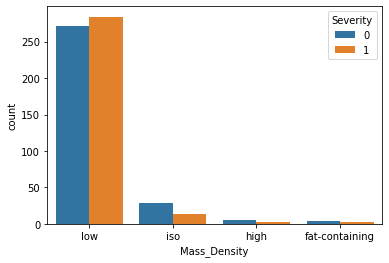

In [49]:
grouped = x_train_pd.groupby('Mass_Density')
age_mean = grouped.count()

sns.countplot(x="Mass_Density", data=x_train_pd, hue="Severity")

Here we have class imbalance, we have less observations for iso, high, fat-containing densities.

We need to collect enough records for such imbalanced observations. This type of data will definitly affect the decision making.

Here, for every Mass-category we have nearly equal probability for Malignant OR benign

# Data Encoding.

As we know from problem definition that, **BI-RADS** and **Density** are ordinal data, So We should use **LabelEncoding** for such data.

**Shape** and **Margin** are nominal data, so lets use **OneHotEncoding** for such data.

## Why we should not use LableEncoding for nominal data?

Its because, LableEncoder will assign numetic accending values to nominal data. That is we can can rank/sort this data. Hence there is a very high probability that the model captures the relationship between Margins such as spiculated < circumscribed < ill-defined.


## In our case...

I am not using the LableEncoder from sklearn rather replacing/mapping the values as given in the problem statement.

In [50]:
x_train_pd['Density'] = x_train_pd['Mass_Density'].map({'high':1, 'iso':2, 'low':3, 'fat-containing': 4 })

x_train_pd.drop(['Mass_Density'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:
x_train_pd

,BI_RADS,Age,Shape,Margin,Severity,Density
0,5.0,67.0,lobular,spiculated,1,3
1,5.0,58.0,irregular,spiculated,1,3
2,4.0,28.0,round,circumscribed,0,3
3,5.0,57.0,round,spiculated,1,3
4,5.0,76.0,round,ill-defined,1,3
...,...,...,...,...,...,...
605,5.0,5.0,irregular,ill-defined,1,2
606,5.0,62.0,irregular,ill-defined,1,2
607,4.0,56.0,oval,circumscribed,0,3
608,5.0,58.0,irregular,ill-defined,1,3


In [52]:
shape_onehotencoder = OneHotEncoder()


shape_intermediate = shape_onehotencoder.fit_transform(x_train_pd['Shape'].values.reshape(-1,1)).toarray()
df_shape_OneHot = pd.DataFrame(shape_intermediate, columns = ["Shape_"+str(int(i)) for i in range(shape_intermediate.shape[1])]) 

# print(x_train_pd.shape)
# print(df_shape_OneHot.shape)
x_train_pd = pd.concat([x_train_pd, df_shape_OneHot],axis=1)
x_train_pd.drop(['Shape'],  inplace=True, axis=1) 


# x_train_pd['Margin'] = margin_onehotencoder.fit_transform(x_train_pd['Margin'])

In [53]:
margin_onehotencoder = OneHotEncoder()


margin_intermediate = margin_onehotencoder.fit_transform(x_train_pd['Margin'].values.reshape(-1,1)).toarray()
df_margin_OneHot = pd.DataFrame(margin_intermediate, columns = ["Margin_"+str(int(i)) for i in range(margin_intermediate.shape[1])]) 
x_train_pd = pd.concat([x_train_pd, df_margin_OneHot], axis=1)
x_train_pd.drop(['Margin'], inplace=True, axis=1) 


# x_train_pd['Margin'] = margin_onehotencoder.fit_transform(x_train_pd['Margin'])

In [54]:
x_train_pd

,BI_RADS,Age,Severity,Density,Shape_0,Shape_1,Shape_2,Shape_3,Margin_0,Margin_1,Margin_2,Margin_3,Margin_4
0,5.0,67.0,1,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.0,58.0,1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4.0,28.0,0,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,5.0,57.0,1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,76.0,1,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,5.0,5.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
606,5.0,62.0,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
607,4.0,56.0,0,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
608,5.0,58.0,1,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Same operataions on test data

In [55]:
x_test_pd = test_pd.dropna()
x_test_pd.reset_index(drop=True, inplace=True)
print("%d records in test, after dropna" %(len(x_test_pd)))

x_test_pd['Density'] = x_test_pd['Mass_Density'].map({'high':1, 'iso':2, 'low':3, 'fat-containing': 4 })
x_test_pd.drop(['Mass_Density'], inplace=True, axis=1)

y_test_pd = x_test_pd['Severity']
x_test_pd.drop(['Severity'], inplace=True, axis=1)

shape_intermediate = shape_onehotencoder.transform(x_test_pd['Shape'].values.reshape(-1,1)).toarray()
df_shape_OneHot = pd.DataFrame(shape_intermediate, columns = ["Shape_"+str(int(i)) for i in range(shape_intermediate.shape[1])]) 
x_test_pd = pd.concat([x_test_pd, df_shape_OneHot],axis=1)
x_test_pd.drop(['Shape'],  inplace=True, axis=1) 


margin_intermediate = margin_onehotencoder.fit_transform(x_test_pd['Margin'].values.reshape(-1,1)).toarray()
df_margin_OneHot = pd.DataFrame(margin_intermediate, columns = ["Margin_"+str(int(i)) for i in range(margin_intermediate.shape[1])]) 
x_test_pd = pd.concat([x_test_pd, df_margin_OneHot], axis=1)
x_test_pd.drop(['Margin'], inplace=True, axis=1) 


x_test_pd

137 records in test, after dropna


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,BI_RADS,Age,Density,Shape_0,Shape_1,Shape_2,Shape_3,Margin_0,Margin_1,Margin_2,Margin_3,Margin_4
0,5,65.0,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5,74.0,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4,57.0,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,76.0,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,63.0,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
132,4,47.0,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
133,4,56.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
134,4,64.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
135,5,66.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [56]:
y = x_train_pd['Severity']
X = x_train_pd.drop(['Severity'], axis=1)

In [57]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.25, random_state=0)


# Lets try DecisionTreeClasifier

In [58]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
clf.score(X_val, y_val)

0.7516339869281046

# Lets Drop **Density**

As we seen as part of EDA, **Density** is not that significant for decision making. Lets drop and see if score improves.

In [59]:
wod_X_train = X_train.drop(['Density'], axis=1)
wod_X_val = X_val.drop(['Density'], axis=1)


In [60]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(wod_X_train, y_train)
y_pred = clf.predict(wod_X_val)
clf.score(wod_X_val, y_val)

0.7712418300653595

So, removing **Density** is actually beneficial atleast with DecisionTreeClassifier.

Some algorithms are robust to such redundant features, eg. RandomForest, neural networks. Retaining such feautures results in unnecessary computations, which can make traing and inferencig very slow specially when we have huge redundant features.

# HyperParameter search using GridSearchCV.

We are getting good score with Decision Tree. The decision tree classifier uses only one tree.

To increase the accuracy we can try using RandomForest, where multiple trees will be used. This time we will also try to search the best paramters for the RandomForest.

We can also use RandomSearchCV, where we define the distributions for the hyper-parameters and RandomSearchCV will take some random parametrers out of those distribution to find the best paramerers.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 80, 100],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [150, 200, 225, 300]
}


In [25]:
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  7.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [27]:

pp.pprint(grid_search.best_params_)

best_search = grid_search.best_estimator_
print("\n")
pp.pprint(model_selection.cross_val_score(best_search, X, y, cv=5))
y_pred = best_search.predict(X_val)

print("\nMean Accuracy: %s" %(best_search.score(X_val, y_val)))

{   'bootstrap': True,
    'max_depth': 80,
    'max_features': 1,
    'min_samples_leaf': 4,
    'min_samples_split': 8,
    'n_estimators': 300}


array([0.83606557, 0.85245902, 0.89344262, 0.80327869, 0.8442623 ])

Mean Accuracy: 0.8169934640522876


In [28]:
# Create a based model
rf2 = RandomForestClassifier()

# Instantiate the grid search model
grid_search2 = GridSearchCV(estimator = rf2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)

# Fit the grid search to the data
grid_search2.fit(wod_X_train, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  7.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [29]:
pp.pprint(grid_search2.best_params_)

best_search2 = grid_search2.best_estimator_
print("\n")
pp.pprint(model_selection.cross_val_score(best_search2, X.drop(['Density'], axis=1), y, cv=5))
y_pred2 = best_search2.predict(wod_X_val)

print("\nMean Accuracy: %s" %(best_search2.score(wod_X_val, y_val)))

{   'bootstrap': True,
    'max_depth': 100,
    'max_features': 1,
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 150}


array([0.8442623 , 0.86065574, 0.89344262, 0.80327869, 0.8442623 ])

Mean Accuracy: 0.8300653594771242


Again we have observed that, dropping **Density** is giving better results on train and validation dataset. 

# Accurecy on real test dataset.

<u> **BIG NOTE:** Somehow we have access to real predictions for test data as well. Usually this is not the case. Perhaps lets analyse model and consider this test data as a prduction data.</u>

In [62]:
print("\nMean Accuracy with Density: %s" %(best_search.score(x_test_pd, y_test_pd)))

print("\nMean Accuracy without Density: %s" %(best_search2.score(x_test_pd.drop(['Density'], axis=1), y_test_pd)))


Mean Accuracy with Density: 0.8102189781021898

Mean Accuracy without Density: 0.7956204379562044


Surprisingly, on test dataset we are getting better accurecy if we consider Density feature.

This might be due to the fact that our test dataset might have different distribution for Density.

OR we might have to consider few more parameters while GridSearch, so that we will get even more optimised model. 

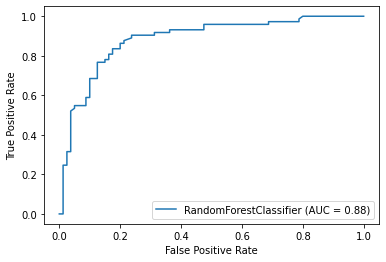

In [63]:
from sklearn import metrics

metrics.plot_roc_curve(best_search, X_val, y_val)

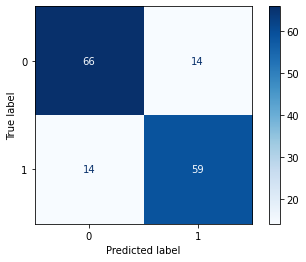

In [64]:
disp = metrics.plot_confusion_matrix(best_search, X_val, y_val,
                                 cmap=plt.cm.Blues)

In [76]:
conf_mtx = disp.confusion_matrix

In [90]:
tn, fp, fn, tp = conf_mtx.ravel()

print("tn, fp, fn, tp", tn, fp, fn, tp)
print("Type_1_Error (fp): ", fp)
print("Type_2_Error (fn): ", fn)

# percentage of wrong predictions of this model 
print("probability of Type_1: Error", fp/tn)
print("probability of Type_2 Error: ", fn/tp)

tn, fp, fn, tp 66 14 14 59
Type_1_Error (fp):  14
Type_2_Error (fn):  14
probability of Type_1:  0.21212121212121213
probability of Type_1:  0.23728813559322035


This means there is 21% chance that, our model will say patient is Severe when he is not.

Also, 23% chance that, our model will say say patient is NOT Severe when he is.

Now, Some doctors might say, 23% is big percentage when we dont intimate the patient that he is Severe. It is perfectly ok if we say Severe when patient is actualy not Severe. 

# How to tackle this situation?

We can decrese the decision threshold for the model. By default it is 0.5 lets let it to 0.3 and calculate the errors again.

Accuracy:  0.7777777777777778


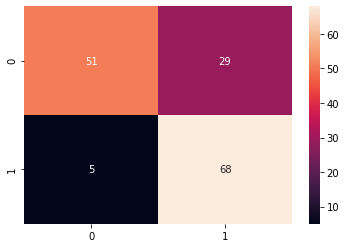

In [99]:
y_pred_3 = (best_search.predict_proba(X_val)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

conf_mtx2 = metrics.confusion_matrix(y_val, y_pred_3)

print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_3))


sns.heatmap(conf_mtx2, annot=True)


In [96]:
tn, fp, fn, tp = conf_mtx2.ravel()

print("tn, fp, fn, tp", tn, fp, fn, tp)
print("Type_1_Error (fp): ", fp)
print("Type_2_Error (fn): ", fn)

# percentage of wrong predictions of this model 
print("probability of Type_1 Error: ", fp/tn)
print("probability of Type_2 Error: ", fn/tp)

tn, fp, fn, tp 51 29 5 68
Type_1_Error (fp):  29
Type_2_Error (fn):  5
probability of Type_1 Error:  0.5686274509803921
probability of Type_2 Error:  0.07352941176470588


Now Type_2 error is reduced dramatically. Now doctor can confidently say that patient is not in Severe condition.

**NOTE: ** By changing threshold the accurecy has changed a lot, which is obvious.

# Apply very simple algorithm MultinomialNB

In [65]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
# clf.score(X_test,y_test)
scores = model_selection.cross_val_score(clf,X,y,cv=10)
print(scores)
print(scores.mean())

[0.72131148 0.78688525 0.83606557 0.78688525 0.83606557 0.86885246
 0.67213115 0.85245902 0.75409836 0.81967213]
0.7934426229508198


We are getting good results with MultinomialNB as well.

# Now Which one to choose from? 

We should choose RandomForestClassifier as it is giving giving better result. On the other hand although RandomForestClassifier is quite fast still, if we want exteramly faster algorithm and ready to compromise slightly on accuray then MultinomialNB should be the choice.